In [1]:
import numpy as np
import arms
import matplotlib.pyplot as plt

In [2]:
def produce_loss_sequence(env, T, env_change=False, new_env=None, change_time=None):
    K = len(env)
    loss_sequence = []
    if env_change:
        for _ in range(change_time):
            loss_sequence.append([arm.sample() for arm in env])
        for _ in range(int(T - change_time)):
            loss_sequence.append([arm.sample() for arm in new_env])
    else:
        for _ in range(T):
            loss_seqeunce.append([arm.sample() for arm in env])
    return np.array(loss_sequence)

In [3]:
def EXP3_IX(loss_sequence, eta, gamma, T):
    '''This function implements the EXP3-iX algorithm
    env: usered defined environment
    eta:
    gamma:
    T:
    '''
    K = loss_sequence.shape[1]
    w = np.ones(K)
    loss = []
    draws = []

    for i in range(int(T)):
        # agent choose arm
        #w = w / np.min(w)
        w = w / w[0]
        p = w / np.sum(w)
        #print(i, ":, ", w)
        I = np.random.choice(K, p=p)
        draws.append(I)

        # observe loss
        l = loss_sequence[i, I]
        loss.append(l)
        l = l / (p[I] + gamma)
        w[I] = w[I] * np.exp(-eta * l)
    return draws, loss

In [69]:
def EXP3(loss_sequence, eta, gamma, T):
    K = loss_sequence.shape[1]
    w = np.ones(K)
    
    loss = []
    draws = []  
    
    for i in range(int(T)):
        w = w / np.max(w)
        #print(w)
        p = w / np.sum(w)        
        p = (1 - gamma) * p + gamma / K
        I = np.random.choice(K, p=p)
        draws.append(I)

        # observe loss
        l = loss_sequence[i, I]
        loss.append(l)
        
        l /= p[I]
        w[I] = w[I] * np.exp(-eta * l)
    return draws, loss

In [107]:
def EXP3_P(loss_sequence, eta, gamma, beta, T):
    K = loss_sequence.shape[1]
    w = np.ones(K)
    #w = np.exp(alpha * gamma * np.sqrt(T / K) / 3) * w
    
    loss = []
    draws = []  
    
    for i in range(int(T)):
        w = w / np.max(w)
        #print(w)
        p = w / np.sum(w)        
        p = (1 - gamma) * p + gamma / K
        I = np.random.choice(K, p=p)
        draws.append(I)

        # observe loss
        l = loss_sequence[i, I]
        loss.append(l)
        
        l /= p[I]
        x = np.zeros(K)
        x[I] += l
        
        x = x - beta / p
        #print(x)
        w = w * np.exp(-eta * x)
    return draws, loss

In [5]:
random_state = np.random.randint(1, 312414)

delta = 0.1
# Bernoulli loss arm
arm1 = arms.ArmBernoulli(0.50, random_state=random_state)
arm2 = arms.ArmBernoulli(0.50, random_state=random_state)
arm3 = arms.ArmBernoulli(0.50, random_state=random_state)
arm4 = arms.ArmBernoulli(0.50, random_state=random_state)
arm5 = arms.ArmBernoulli(0.50, random_state=random_state)
arm6 = arms.ArmBernoulli(0.50, random_state=random_state)
arm7 = arms.ArmBernoulli(0.50, random_state=random_state)
arm8 = arms.ArmBernoulli(0.50, random_state=random_state)
arm9 = arms.ArmBernoulli(0.50-delta, random_state=random_state)
arm10_1 = arms.ArmBernoulli(0.50+delta, random_state=random_state)
arm10_2 = arms.ArmBernoulli(0.50-4*delta, random_state=random_state)

MAB1 = [arm1, arm2, arm3, arm4, arm5, arm6, arm7, arm8, arm9, arm10_1]
MAB2 = [arm1, arm2, arm3, arm4, arm5, arm6, arm7, arm8, arm9, arm10_2]

T = 1e4
K = len(MAB1)
change_time = int(T/2)

loss_sequence = produce_loss_sequence(env=MAB1, T=T, env_change=True, new_env=MAB2, change_time=change_time)

single_global_best = np.min(np.sum(loss_sequence, axis=0))
single_global_best_2 = np.min(np.sum(loss_sequence[: int(T/2)], axis=0))

In [111]:
etas = [10**i for i in np.linspace(-2.5, 0, 8)]
repeat = 50
regrets_ix = []
regrets_exp3 = []
regrets_exp3p = []
#regrets = []
#regrets_2 = []
for eta in etas:
    tmp_ix = [[], []]
    tmp_exp3 = [[], []]
    tmp_exp3p = [[], []]
    #gamma = np.min([0.6, 2*np.sqrt(0.6 * K * np.log(K) / T)])
    gamma = 0.005
    #alpha = 2 * np.sqrt(np.log(K * T / 0.01))
    #beta = 0.006
    beta = gamma / K
    for _ in range(repeat):
        _, loss = EXP3_P(loss_sequence=loss_sequence, 
                         eta=eta, 
                         gamma=gamma,
                         beta=beta,
                         T=T)
        tmp_exp3p[0].append(np.sum(loss) - single_global_best)
        tmp_exp3p[1].append(np.sum(loss[:change_time]) - single_global_best_2)
        
        _, loss = EXP3(loss_sequence=loss_sequence, 
                 eta=eta, 
                 gamma=gamma,
                 T=T)
        tmp_exp3[0].append(np.sum(loss) - single_global_best)
        tmp_exp3[1].append(np.sum(loss[:change_time]) - single_global_best_2)
        
        _, loss = EXP3_IX(loss_sequence=loss_sequence, 
                 eta=eta, 
                 gamma=gamma,
                 T=T)
        tmp_ix[0].append(np.sum(loss) - single_global_best)
        tmp_ix[1].append(np.sum(loss[:change_time]) - single_global_best_2)
    #print('eta: %0.3f, regret: %f' % (eta, np.mean(tmp)))
    regrets_ix.append(tmp_ix)
    regrets_exp3.append(tmp_exp3)
    regrets_exp3p.append(tmp_exp3p)
    
regrets_ix = np.array(regrets_ix)
regrets_exp3p = np.array(regrets_exp3p)
regrets_exp3 = np.array(regrets_exp3)

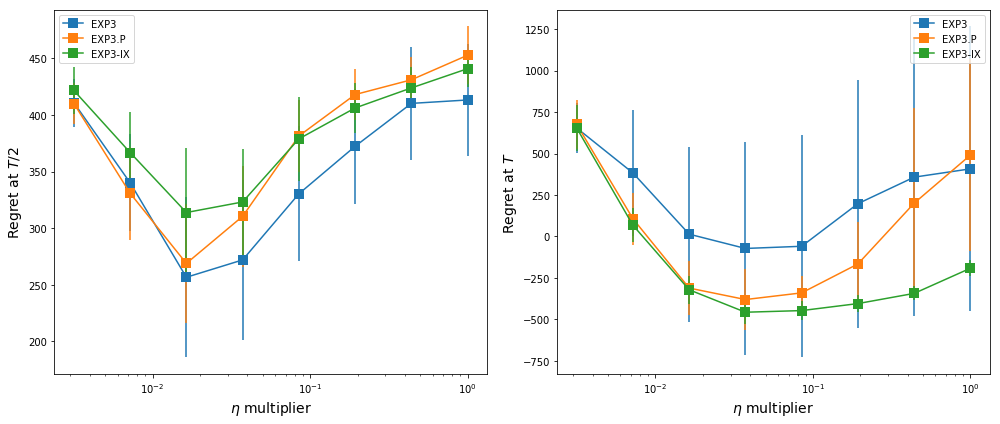

In [133]:
std_ix = np.std(regrets_ix, axis=2).T
mean_ix = np.mean(regrets_ix, axis=2).T

std_exp3 = np.std(regrets_exp3, axis=2).T
mean_exp3 = np.mean(regrets_exp3, axis=2).T

std_exp3p = np.std(regrets_exp3p, axis=2).T
mean_exp3p = np.mean(regrets_exp3p, axis=2).T

means = [mean_exp3, mean_exp3p, mean_ix]
stds = [std_exp3, std_exp3p, std_ix]

algos = ['EXP3', 'EXP3.P', 'EXP3-IX']
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(14, 6))
for i in range(len(algos)):
    ax1.errorbar(etas, means[i][1], yerr=stds[i][1], fmt='-o',mew=4,  marker='s', label=algos[i])
    #ax1.errorbar(etas, means[i][1], fmt='-o', label=algos[i])
    #ax1.fill_between(etas, means[i][1]-stds[i][1], means[i][1]+stds[i][1],
    #alpha=0.3, antialiased=True)
ax1.set_xscale('log')
ax1.set_xlabel(r'$\eta$ multiplier', fontsize=14)
ax1.set_ylabel(r'Regret at $T/2$', fontsize=14)
ax1.legend()

for i in range(len(algos)):
    ax2.errorbar(etas, means[i][0], yerr=stds[i][0], fmt='-o',mew=4,  marker='s', label=algos[i])
    #ax2.errorbar(etas, means[i][0], fmt='-o', label=algos[i])
    #ax2.fill_between(etas, means[i][0]-stds[i][0], means[i][0]+stds[i][0],
    #alpha=0.3, antialiased=True)
ax2.set_xscale('log')
ax2.set_xlabel(r'$\eta$ multiplier', fontsize=14)
ax2.set_ylabel(r'Regret at $T$', fontsize=14)
ax2.legend()
plt.tight_layout()
plt.savefig('../../../../Desktop/images/arm10_notfill.png')
plt.show()

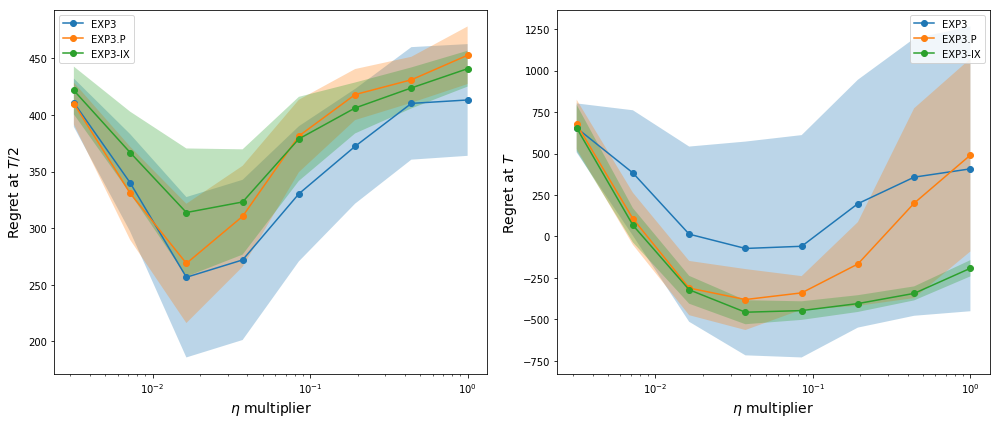

In [132]:
std_ix = np.std(regrets_ix, axis=2).T
mean_ix = np.mean(regrets_ix, axis=2).T

std_exp3 = np.std(regrets_exp3, axis=2).T
mean_exp3 = np.mean(regrets_exp3, axis=2).T

std_exp3p = np.std(regrets_exp3p, axis=2).T
mean_exp3p = np.mean(regrets_exp3p, axis=2).T

means = [mean_exp3, mean_exp3p, mean_ix]
stds = [std_exp3, std_exp3p, std_ix]

algos = ['EXP3', 'EXP3.P', 'EXP3-IX']
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(14, 6))
for i in range(len(algos)):
    ax1.errorbar(etas, means[i][1], fmt='-o', label=algos[i])
    ax1.fill_between(etas, means[i][1]-stds[i][1], means[i][1]+stds[i][1],
    alpha=0.3, antialiased=True)
ax1.set_xscale('log')
ax1.set_xlabel(r'$\eta$ multiplier', fontsize=14)
ax1.set_ylabel(r'Regret at $T/2$', fontsize=14)
ax1.legend()

for i in range(len(algos)):
    #ax2.errorbar(etas, means[i][0], yerr=stds[i][0], fmt='-o',mew=4,  marker='s', label=algos[i])
    ax2.errorbar(etas, means[i][0], fmt='-o', label=algos[i])
    ax2.fill_between(etas, means[i][0]-stds[i][0], means[i][0]+stds[i][0],
    alpha=0.3, antialiased=True)
ax2.set_xscale('log')
ax2.set_xlabel(r'$\eta$ multiplier', fontsize=14)
ax2.set_ylabel(r'Regret at $T$', fontsize=14)
ax2.legend()
plt.tight_layout()
plt.savefig('../../../../Desktop/images/arm10.png')
plt.show()